# core

> Fill in a module description here

In [1]:
#| default_exp core

In [2]:
%load_ext autoreload
%autoreload 2


In [3]:
#| hide
from nbdev.showdoc import *
import random

In [4]:
#| export
def foo(): pass

In [5]:
from datasets import load_dataset
ds_trn = load_dataset("hasangoni/Electron_microscopy_dataset", split="train")
ds_tst = load_dataset("hasangoni/Electron_microscopy_dataset", split="test")

In [6]:
#| export
from cv_tools.imports import *
from cv_tools.core import *

In [7]:
#| export
from fastcore.all import *
from fastcore.test import *
import matplotlib.pyplot as plt

In [8]:
#| export
# torch related imports
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np

In [9]:

# Load pretrained DINOv2 (ViT-Large recommended for best features)
dinov2 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
print(f"Model loaded. Embedding dim: {dinov2.embed_dim}")


Using cache found in /home/hasan/.cache/torch/hub/facebookresearch_dinov2_main
/home/hasan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/hasan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/hasan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


Model loaded. Embedding dim: 1024


In [10]:
global_crop = transforms.Compose(
	[transforms.RandomResizedCrop(224),
	transforms.RandomHorizontalFlip(),
	# Converts a PIL Image or numpy.ndarray to a torch.FloatTensor of shape (C x H x W) and scales the image's pixel intensity values to the range [0, 1]
	transforms.ToTensor(),
	transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]
)

In [11]:
local_crop = transforms.Compose(
	[
		# For "local" image crops, we use a smaller output size (96x96). This matches DINO's protocol where local views are smaller, forcing the model to learn from less context.
		# The scale parameter determines the range of the area of the original image to be cropped (as a fraction of the image area).
		# Here, scale=(0.05, 0.4) means each crop will cover between 5% and 40% of the input image area.
		transforms.RandomResizedCrop(96, scale=(0.05, 0.4)),
		transforms.RandomHorizontalFlip(),
		transforms.ToTensor(),
		transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
		])

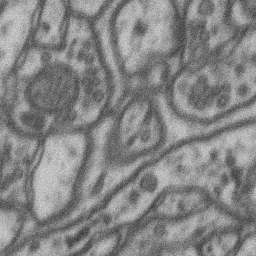

In [12]:
IDX = 0
img = ds_trn[IDX]['image'].convert('RGB')
img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.91917115..1.5942485].


 len(crops) = 10


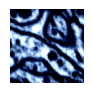

In [13]:
N_GLOBAL = 2
N_LOCAL = 8
crops = []
crops = [global_crop(img) for _ in range(N_GLOBAL)]
crops += [local_crop(img) for _ in range(N_LOCAL)]
print(f' len(crops) = {len(crops)}')

random_crop = random.choice(crops)
show_(random_crop.permute(1, 2, 0))


In [14]:
#| export
class MultiCropDataset(torch.utils.data.Dataset):
    __repr_attrs__ = ['ds', 'image_column', 'n_global', 'n_local']
    def __init__(
        self,
        ds,
        image_column='image',
        n_global=2,
        n_local=8,
        global_crop=None,
        local_crop=None,
    ):
        store_attr()
        if global_crop is None:
            self.global_crop = transforms.Compose([
                transforms.RandomResizedCrop(224),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
        if local_crop is None:
            self.local_crop = transforms.Compose([
                transforms.RandomResizedCrop(96, scale=(0.05, 0.4)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
    
    # Optional: define a custom repr
    def __repr__(self):
        return f"MultiCropDataset(ds={self.ds}, image_column={self.image_column}, n_global={self.n_global}, n_local={self.n_local})"

    def __getitem__(self, idx):
        img = self.ds[idx][self.image_column]
        if isinstance(img, dict):
            img = img['image'] if 'image' in img else img
        if not hasattr(img, 'convert'):
            img = transforms.ToPILImage()(img) if torch.is_tensor(img) else img
        img = img.convert('RGB') if hasattr(img, 'convert') else img
        crops = []
        crops = [self.global_crop(img) for _ in range(self.n_global)]
        crops += [self.local_crop(img) for _ in range(self.n_local)]
        return crops

    def __len__(self):
        return len(self.ds)
   

In [15]:
#| export
@patch_to(MultiCropDataset)
def _denormalize(self, tensor):
    """Denormalize tensor for display"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor * std + mean


In [16]:
#| export
@patch_to(MultiCropDataset)
def show_ds(self, n=4, scale=1):
    """Show n samples from the dataset with all their crops"""
    n = min(n, len(self.ds))
    n_crops = self.n_global + self.n_local
        
    # Create figure with proper layout
    fig, axs = plt.subplots(n, n_crops, figsize=(n_crops * 2 * scale, n * 2 * scale))
    if n == 1:
        axs = axs.reshape(1, -1)
        
    for i in range(n):
        # Get image and generate crops
        img = self.ds[i][self.image_column]
        if isinstance(img, dict):
            img = img['image'] if 'image' in img else img
        if not hasattr(img, 'convert'):
            img = transforms.ToPILImage()(img) if torch.is_tensor(img) else img
        img = img.convert('RGB') if hasattr(img, 'convert') else img
            
        # Generate crops for this image
        crops = []
        crops = [self.global_crop(img) for _ in range(self.n_global)]
        crops += [self.local_crop(img) for _ in range(self.n_local)]
            
        # Display each crop
        for j, crop in enumerate(crops):
            ax = axs[i, j] if n > 1 else axs[j]
            # Denormalize and convert to display format
            crop_display = self._denormalize(crop).clamp(0, 1)
            crop_display = crop_display.permute(1, 2, 0).cpu().numpy()
            ax.imshow(crop_display)
            ax.axis('off')
            # Add labels for first row
            if i == 0:
                label = 'Global' if j < self.n_global else 'Local'
                ax.set_title(label, fontsize=8)
        
    plt.tight_layout()
    plt.show()


In [17]:
#| export
@patch_to(torch.utils.data.Dataset)
def show_ds(self, idxs=None, crop_size=None, max_n=9, show=True, **kwargs):
    """Show samples from a PyTorch dataset with optional cropping.
    
    Args:
        idxs: List of indices to show. If None, shows first max_n samples.
        crop_size: If provided, applies center crop of this size to images.
        max_n: Maximum number of samples to show if idxs is None.
        show: If True, displays the plot. If False, returns the figure.
    """
    if idxs is None: idxs = L.range(max_n)
    if not show: return self[idxs]
    
    fig, axs = plt.subplots(len(idxs), 1, figsize=(3, 3 * len(idxs)))
    if len(idxs) == 1: axs = [axs]  # Ensure axs is iterable even for a single image

    for i, idx in enumerate(idxs):
        item = self[idx]
        
        # Handle different dataset return formats
        if isinstance(item, (list, tuple)):
            img, label = item[0], item[1] if len(item) > 1 else None
        else:
            img, label = item, None
        
        # Convert to PIL Image if needed
        if isinstance(img, torch.Tensor):
            # Handle batch dimension if present
            if img.dim() == 4:  # Batch dimension
                img = img[0]
            # Convert tensor to PIL Image
            img = transforms.ToPILImage()(img)
        # Apply cropping if crop_size is provided
        if crop_size:
            transform = transforms.CenterCrop(crop_size)
            img = transform(img)
        
        axs[i].imshow(img)
        if label is not None:
            axs[i].set_title(f"Label: {label}")
        axs[i].axis('off')
    
    plt.tight_layout()
    plt.show()


In [18]:
torch_ds_trn = MultiCropDataset(ds_trn)
torch_ds_val = MultiCropDataset(ds_tst)
torch_ds_trn

MultiCropDataset(ds=Dataset({
    features: ['image', 'label'],
    num_rows: 1642
}), image_column=image, n_global=2, n_local=8)

In [19]:
torch_ds_trn

MultiCropDataset(ds=Dataset({
    features: ['image', 'label'],
    num_rows: 1642
}), image_column=image, n_global=2, n_local=8)

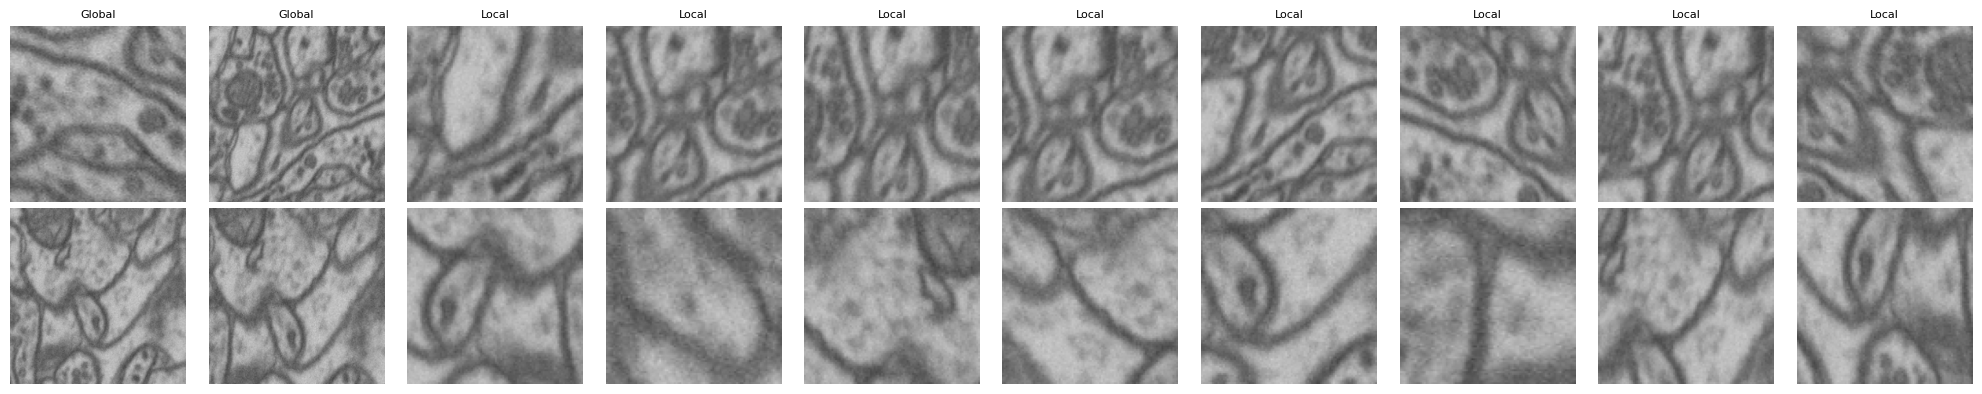

In [20]:
torch_ds_trn.show_ds(scale=1, n=2)

## Dataloader

In [22]:
trn_dl = DataLoader(
    torch_ds_trn,
    batch_size=16,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
)


In [23]:
bs = next(iter(trn_dl))
print(f'type(bs) = {type(bs)}')
print(f"Number of crops: {len(bs)}")
print(f"Global crop 1 shape: {bs[0].shape}")
print(f"Local crop 1 shape: {bs[2].shape}")
test_eq(bs[0].shape, torch.Size([16, 3, 224, 224]))
test_eq(bs[2].shape, torch.Size([16, 3, 96, 96]))


type(bs) = <class 'list'>
Number of crops: 10
Global crop 1 shape: torch.Size([16, 3, 224, 224])
Local crop 1 shape: torch.Size([16, 3, 96, 96])


In [24]:

print(f"\nBatch contains {len(bs)} crops per sample:")
print(f"  - {torch_ds_trn.n_global} global crops (224x224)")
print(f"  - {torch_ds_trn.n_local} local crops (96x96)")


Batch contains 10 crops per sample:
  - 2 global crops (224x224)
  - 8 local crops (96x96)


In [25]:
#| export
def denorm(tnsr):
    mn =  torch.tnsr([0.485, 0.456, 0.406]).view(3,1,1)
    std = torch.tnsr([0.229, 0.224, 0.225]).view(3,1,1)
    return (tnsr * std + mn).clamp(0,1)

In [26]:
#| export
def create_dl(
    ds, # torch dataset
    batch_size:int=16, # batch size
    shuffle:bool=True, # shuffle data
    num_workers:int=0, # number of workers for multiprocessing
    pin_memory:bool=True, # If True, DataLoader copies tensors into CUDA pinned memory before returning them. This can accelerate data transfer to GPU.
    drop_last:bool=False, # If True, drop the last incomplete batch if the dataset size is not divisible by the batch size.
):
    """Create a DataLoader for a given dataset."""
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        pin_memory=pin_memory,
        drop_last=drop_last
    )

In [36]:
BATCH_SIZE = 2
trn_dls = create_dl(torch_ds_trn, batch_size=BATCH_SIZE)
val_dls = create_dl(torch_ds_val, batch_size=BATCH_SIZE)


In [37]:
trn_bs = next(iter(trn_dls))
print(f"Number of crops: {len(trn_bs)}")
print(f"Global crop 1 shape: {trn_bs[0].shape}")
print(f"Local crop 1 shape: {trn_bs[2].shape}")






Number of crops: 10
Global crop 1 shape: torch.Size([2, 3, 224, 224])
Local crop 1 shape: torch.Size([2, 3, 96, 96])


In [38]:
#| export
def visualize_dataloader_batch(
    dataloader,
    n_samples=4,
    denormalize=True,
    figsize=None,
    random_batch=True
):
    """Visualize a batch from DataLoader showing all crops
    
    Args:
        dataloader: DataLoader instance
        n_samples: Number of samples from batch to show (default: 4)
        denormalize: Whether to denormalize images (default: True)
        figsize: Figure size (default: auto-calculated)
        random_batch: If True, get random batch; if False, get first batch (default: True)
    """
    # Get a batch
    if random_batch:
        # Get random batch
        import random
        batch_idx = random.randint(0, len(dataloader) - 1)
        for i, batch in enumerate(dataloader):
            if i == batch_idx:
                crops = batch
                break
    else:
        # Get first batch
        crops = next(iter(dataloader))
    
    # Determine number of crops
    n_crops = len(crops)
    batch_size = crops[0].shape[0]
    n_samples = min(n_samples, batch_size)
    
    # Denormalization function
    def denorm(tensor):
        if denormalize:
            mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
            return (tensor * std + mean).clamp(0, 1)
        return tensor.clamp(0, 1)
    
    # Calculate figure size
    if figsize is None:
        figsize = (n_crops * 2, n_samples * 2)
    
    # Create figure
    fig, axs = plt.subplots(n_samples, n_crops, figsize=figsize)
    if n_samples == 1:
        axs = axs.reshape(1, -1)
    
    # Plot each sample and its crops
    for i in range(n_samples):
        for j in range(n_crops):
            # Get crop
            crop = crops[j][i]  # [C, H, W]
            
            # Denormalize and convert to display format
            crop_display = denorm(crop).permute(1, 2, 0).cpu().numpy()
            
            # Display
            axs[i, j].imshow(crop_display)
            axs[i, j].axis('off')
            
            # Add title for first row
            if i == 0:
                crop_type = 'Global' if j < 2 else 'Local'  # Assuming 2 global crops
                crop_size = crop.shape[1]  # Height
                axs[i, j].set_title(f'{crop_type}\n{crop_size}x{crop_size}', fontsize=9)
    
    # Add row labels
    for i in range(n_samples):
        axs[i, 0].text(-0.1, 0.5, f'Sample {i+1}', 
                      transform=axs[i, 0].transAxes,
                      fontsize=10, va='center', ha='right', rotation=90)
    
    plt.suptitle(f'DataLoader Batch Visualization ({n_samples} samples, {n_crops} crops each)', 
                fontsize=12, y=0.98)
    plt.tight_layout()
    plt.show()
    
    # Print batch info
    print(f"\nBatch Information:")
    print(f"  Batch size: {batch_size}")
    print(f"  Number of crops: {n_crops}")
    print(f"  Showing: {n_samples} samples")
    for j, crop in enumerate(crops):
        crop_type = 'Global' if j < 2 else 'Local'
        print(f"  Crop {j} ({crop_type}): {list(crop.shape)}")

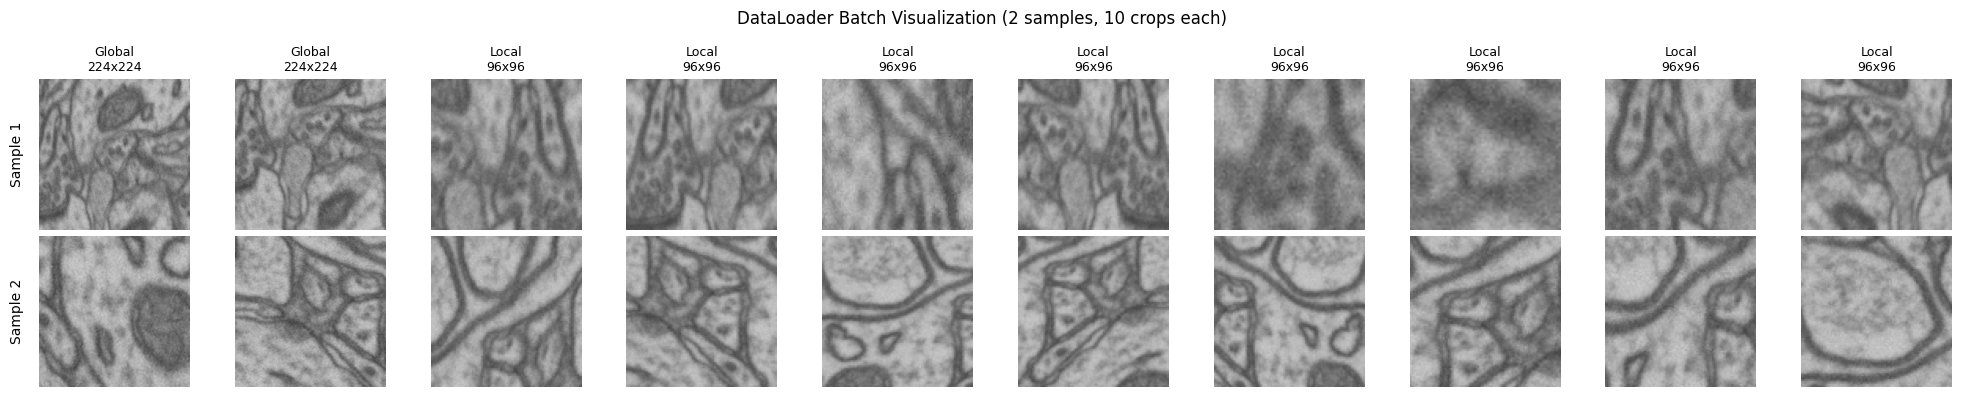


Batch Information:
  Batch size: 2
  Number of crops: 10
  Showing: 2 samples
  Crop 0 (Global): [2, 3, 224, 224]
  Crop 1 (Global): [2, 3, 224, 224]
  Crop 2 (Local): [2, 3, 96, 96]
  Crop 3 (Local): [2, 3, 96, 96]
  Crop 4 (Local): [2, 3, 96, 96]
  Crop 5 (Local): [2, 3, 96, 96]
  Crop 6 (Local): [2, 3, 96, 96]
  Crop 7 (Local): [2, 3, 96, 96]
  Crop 8 (Local): [2, 3, 96, 96]
  Crop 9 (Local): [2, 3, 96, 96]


In [39]:
visualize_dataloader_batch(
    trn_dls,
    random_batch=False
)

In [ ]:
#| export
def visualize_features_tsne(features, labels=None, n_samples=1000):
    """Visualize features using t-SNE (requires sklearn)
    
    Args:
        features: Feature tensor [N, D]
        labels: Optional label tensor [N]
        n_samples: Maximum samples to visualize (default: 1000)
    """
    try:
        from sklearn.manifold import TSNE
    except ImportError:
        print("sklearn not installed. Install with: pip install scikit-learn")
        return
    
    # Sample if too many points
    if len(features) > n_samples:
        indices = np.random.choice(len(features), n_samples, replace=False)
        features = features[indices]
        if labels is not None:
            labels = labels[indices]
    
    # Run t-SNE
    print(f"Running t-SNE on {len(features)} samples...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    features_2d = tsne.fit_transform(features.numpy() if torch.is_tensor(features) else features)
    
    # Plot
    plt.figure(figsize=(10, 8))
    if labels is not None:
        labels_np = labels.numpy() if torch.is_tensor(labels) else labels
        scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], 
                            c=labels_np, cmap='tab10', alpha=0.6, s=20)
        plt.colorbar(scatter, label='Class')
    else:
        plt.scatter(features_2d[:, 0], features_2d[:, 1], alpha=0.6, s=20)
    
    plt.title('t-SNE Visualization of Learned Features', fontsize=14)
    plt.xlabel('t-SNE 1', fontsize=12)
    plt.ylabel('t-SNE 2', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.show()

In [ ]:
# Example: How to use plot_top_losses for error analysis
# Uncomment to run after training

# # After training, analyze which samples had highest losses
# plot_top_losses(
#     student=student,
#     teacher=teacher,
#     dataset=torch_ds_trn,  # or torch_ds_tst for validation
#     loss_fn=loss_fn,
#     device=device,
#     n_samples=10,  # Change to show more/fewer examples
#     save_path='top_losses.png'  # Optional: save figure
# )

# # For validation set:
# # torch_ds_tst = MultiCropDataset(ds_tst, n_global=2, n_local=8)
# # plot_top_losses(student, teacher, torch_ds_tst, loss_fn, device, n_samples=20)

print("plot_top_losses() function ready for error analysis!")
print("\nUsage:")
print("  plot_top_losses(student, teacher, dataset, loss_fn, device, n_samples=10)")
print("\nFeatures:")
print("  - Shows images with highest losses")
print("  - Loss displayed with 2 decimal places")
print("  - Prints loss statistics (mean, std, min, max)")
print("  - Configurable number of samples")
print("  - Can save figure to file")
print("  - Works on training or validation set")

In [ ]:
#| export
def plot_top_losses(
    student,
    teacher,
    dataset,
    loss_fn,
    device='cuda',
    n_samples=10,
    figsize=None,
    save_path=None
):
    """Plot images with highest losses for error analysis
    
    Args:
        student: Student model
        teacher: Teacher model
        dataset: MultiCropDataset instance
        loss_fn: DINO loss function
        device: Device (default: 'cuda')
        n_samples: Number of top loss samples to show (default: 10)
        figsize: Figure size (default: auto-calculated)
        save_path: Optional path to save figure
    """
    # Compute losses for all samples
    print(f"Computing losses for {len(dataset)} samples...")
    losses = compute_sample_losses(student, teacher, dataset, loss_fn, device)
    
    # Get top N highest losses
    top_indices = torch.argsort(losses, descending=True)[:n_samples]
    top_losses = losses[top_indices]
    
    # Calculate grid dimensions
    n_cols = min(5, n_samples)
    n_rows = (n_samples + n_cols - 1) // n_cols
    
    if figsize is None:
        figsize = (n_cols * 3, n_rows * 3)
    
    # Create figure
    fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize)
    if n_samples == 1:
        axs = np.array([axs])
    axs = axs.flatten()
    
    # Plot each top loss image
    for i, (idx, loss) in enumerate(zip(top_indices, top_losses)):
        # Get original image
        img = dataset.ds[idx.item()][dataset.image_column]
        
        # Convert to RGB PIL Image if needed
        if isinstance(img, dict):
            img = img['image'] if 'image' in img else img
        if not hasattr(img, 'convert'):
            img = transforms.ToPILImage()(img) if torch.is_tensor(img) else img
        img = img.convert('RGB') if hasattr(img, 'convert') else img
        
        # Display image
        axs[i].imshow(img)
        axs[i].axis('off')
        axs[i].set_title(f'Idx: {idx.item()}, Loss: {loss.item():.2f}', 
                        fontsize=10, pad=5)
    
    # Hide unused subplots
    for i in range(n_samples, len(axs)):
        axs[i].axis('off')
    
    plt.suptitle(f'Top {n_samples} Highest Loss Samples', fontsize=14, y=0.98)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved to {save_path}")
    
    plt.show()
    
    # Print loss statistics
    print(f"\nLoss Statistics:")
    print(f"  Mean loss: {losses.mean():.2f}")
    print(f"  Std loss: {losses.std():.2f}")
    print(f"  Min loss: {losses.min():.2f}")
    print(f"  Max loss: {losses.max():.2f}")
    print(f"\nTop {n_samples} losses:")
    for i, (idx, loss) in enumerate(zip(top_indices, top_losses), 1):
        print(f"  {i}. Index {idx.item()}: {loss.item():.2f}")

In [ ]:
#| export
@torch.no_grad()
def compute_sample_losses(
    student,
    teacher,
    dataset,
    loss_fn,
    device='cuda',
    batch_size=16
):
    """Compute loss for each sample in dataset
    
    Args:
        student: Student model
        teacher: Teacher model
        dataset: MultiCropDataset instance
        loss_fn: DINO loss function
        device: Device (default: 'cuda')
        batch_size: Batch size for processing (default: 16)
        
    Returns:
        losses: Tensor of shape [N] with loss per sample
    """
    student.eval()
    teacher.eval()
    
    # Create dataloader
    loader = create_dataloader(
        dataset, 
        batch_size=batch_size, 
        shuffle=False,  # Important: keep order
        num_workers=0,
        drop_last=False
    )
    
    all_losses = []
    
    for crops in tqdm(loader, desc="Computing losses"):
        # Move crops to device
        crops = [crop.to(device) for crop in crops]
        
        # Split into global and local crops
        n_global = dataset.n_global
        global_crops = crops[:n_global]
        all_crops = crops
        
        # Get predictions
        student_output = [student(crop) for crop in all_crops]
        teacher_output = [teacher(crop) for crop in global_crops]
        
        # Compute loss per sample in batch
        batch_size = global_crops[0].shape[0]
        
        for i in range(batch_size):
            # Extract single sample outputs
            sample_student = [out[i:i+1] for out in student_output]
            sample_teacher = [out[i:i+1] for out in teacher_output]
            
            # Compute loss for this sample
            loss = loss_fn(sample_student, sample_teacher)
            all_losses.append(loss.item())
    
    return torch.tensor(all_losses)

In [ ]:
#| export
def plot_loss_history(loss_history, save_path=None):
    """Plot training loss over epochs
    
    Args:
        loss_history: List of loss values
        save_path: Optional path to save figure
    """
    plt.figure(figsize=(10, 5))
    plt.plot(loss_history, linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('DINO Training Loss', fontsize=14)
    plt.grid(True, alpha=0.3)
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

## Section 9: Evaluation Utilities (Optional)

Helpful utilities for monitoring training and visualizing learned features.

In [ ]:
# Example: Complete training script
# Uncomment and run this cell to start training

# === Setup ===
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(f"Using device: {device}")

# === Data ===
# train_dataset = MultiCropDataset(ds_trn, n_global=2, n_local=8)
# train_loader = create_dataloader(train_dataset, batch_size=16, num_workers=4)

# print(f"Dataset size: {len(train_dataset)}")
# print(f"Batches per epoch: {len(train_loader)}")

# === Models ===
# dinov2_backbone = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
# student, teacher = create_dino_models(
#     dinov2_backbone,
#     freeze_backbone=False,  # Train entire model (set to True to only train head)
#     device=device
# )

# print(f"Student trainable params: {sum(p.numel() for p in student.parameters() if p.requires_grad):,}")

# === Loss & Optimizer ===
# loss_fn = DINOLoss(out_dim=256, teacher_temp=0.04, student_temp=0.1)
# loss_fn.to(device)

# optimizer = create_optimizer(student, lr=1e-4, weight_decay=0.04)

# scheduler = WarmupCosineSchedule(
#     optimizer,
#     warmup_epochs=10,
#     max_epochs=100,
#     base_lr=1e-4,
#     final_lr=1e-6
# )

# === Training ===
# # Start with a small test run (5 epochs) to verify everything works
# loss_history = train_dino(
#     student=student,
#     teacher=teacher,
#     train_loader=train_loader,
#     loss_fn=loss_fn,
#     optimizer=optimizer,
#     scheduler=scheduler,
#     n_epochs=5,  # Change to 100 for full training
#     device=device,
#     checkpoint_dir='checkpoints',
#     save_every=5
# )

# === Plot loss ===
# plt.figure(figsize=(10, 5))
# plt.plot(loss_history, linewidth=2)
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('DINO Training Loss')
# plt.grid(True, alpha=0.3)
# plt.show()

print("To start training, uncomment the code above and run this cell.")
print("Recommended: Start with 5 epochs to test, then increase to 100 for full training.")

## Section 8: Complete Training Example

This example shows how to put all the pieces together for end-to-end training.

In [ ]:
#| export
def save_features(features, path, labels=None):
    """Save extracted features to file
    
    Args:
        features: Feature tensor
        path: Path to save to
        labels: Optional labels tensor
    """
    save_dict = {'features': features}
    if labels is not None:
        save_dict['labels'] = labels
    torch.save(save_dict, path)
    print(f"Saved features to {path}")

In [ ]:
#| export
@torch.no_grad()
def extract_features(
    model,
    dataloader,
    device='cuda',
    use_head=False
):
    """Extract features from trained model
    
    Args:
        model: Trained DINO model (student or teacher)
        dataloader: DataLoader (should return single crops, not multi-crop)
        device: Device to use (default: 'cuda')
        use_head: If True, use projection head; if False, use backbone features only (default: False)
        
    Returns:
        features: Tensor of shape [N, feature_dim]
    """
    model.eval()
    
    all_features = []
    
    for batch in tqdm(dataloader, desc="Extracting features"):
        # Handle multi-crop dataset (take first global crop)
        if isinstance(batch, list):
            images = batch[0].to(device)
        else:
            # Handle regular dataset
            if isinstance(batch, (list, tuple)) and len(batch) == 2:
                images, _ = batch
            else:
                images = batch
            images = images.to(device)
        
        # Extract features
        if use_head:
            features = model(images)
        else:
            features = model.backbone(images)
        
        all_features.append(features.cpu())
    
    # Concatenate all features
    all_features = torch.cat(all_features, dim=0)
    
    return all_features

## Section 7: Feature Extraction

After training, extract features from the adapted model to use for downstream tasks like segmentation.

In [ ]:
# Cell 6C - Verification: Test checkpoint save/load
import tempfile

# Create temporary directory
temp_dir = Path(tempfile.mkdtemp())

# Create models
checkpoint_student, checkpoint_teacher = create_dino_models(dinov2, device=device)
checkpoint_optimizer = create_optimizer(checkpoint_student)

# Save checkpoint
checkpoint_path = temp_dir / 'test_checkpoint.pth'
save_checkpoint(
    checkpoint_path,
    student=checkpoint_student,
    teacher=checkpoint_teacher,
    optimizer=checkpoint_optimizer,
    scheduler=None,
    epoch=5,
    loss=0.123
)

print(f"Saved checkpoint: {checkpoint_path}")
print(f"File size: {checkpoint_path.stat().st_size / 1024 / 1024:.2f} MB")

# Load checkpoint
new_student, new_teacher = create_dino_models(dinov2, device=device)
epoch, loss = load_checkpoint(checkpoint_path, new_student, new_teacher, device=device)

print(f"\\nLoaded checkpoint from epoch {epoch}, loss {loss:.4f}")
print(f"Checkpoint save/load working correctly!")

In [ ]:
#| export
def load_checkpoint(
    path,
    student,
    teacher,
    optimizer=None,
    scheduler=None,
    device='cuda'
):
    """Load training checkpoint
    
    Args:
        path: Path to checkpoint
        student: Student model
        teacher: Teacher model
        optimizer: Optimizer (optional)
        scheduler: Learning rate scheduler (optional)
        device: Device to load to (default: 'cuda')
        
    Returns:
        epoch, loss from checkpoint
    """
    checkpoint = torch.load(path, map_location=device)
    
    student.load_state_dict(checkpoint['student_state_dict'])
    teacher.load_state_dict(checkpoint['teacher_state_dict'])
    
    if optimizer is not None and 'optimizer_state_dict' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    if scheduler is not None and 'scheduler_state_dict' in checkpoint:
        sched_state = checkpoint['scheduler_state_dict']
        scheduler.current_epoch = sched_state['current_epoch']
        scheduler.warmup_epochs = sched_state['warmup_epochs']
        scheduler.max_epochs = sched_state['max_epochs']
        scheduler.base_lr = sched_state['base_lr']
        scheduler.final_lr = sched_state['final_lr']
    
    return checkpoint['epoch'], checkpoint['loss']

In [ ]:
#| export
def save_checkpoint(
    path,
    student,
    teacher,
    optimizer,
    scheduler,
    epoch,
    loss
):
    """Save training checkpoint
    
    Args:
        path: Path to save checkpoint
        student: Student model
        teacher: Teacher model
        optimizer: Optimizer
        scheduler: Learning rate scheduler
        epoch: Current epoch
        loss: Current loss value
    """
    checkpoint = {
        'epoch': epoch,
        'loss': loss,
        'student_state_dict': student.state_dict(),
        'teacher_state_dict': teacher.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    
    if scheduler is not None:
        checkpoint['scheduler_state_dict'] = {
            'current_epoch': scheduler.current_epoch,
            'warmup_epochs': scheduler.warmup_epochs,
            'max_epochs': scheduler.max_epochs,
            'base_lr': scheduler.base_lr,
            'final_lr': scheduler.final_lr
        }
    
    torch.save(checkpoint, path)

## Section 6: Checkpoint Management

Save and load training state to enable resuming training and using trained models later.

In [ ]:
#| export
from pathlib import Path

def train_dino(
    student,
    teacher,
    train_loader,
    loss_fn,
    optimizer,
    scheduler,
    n_epochs=100,
    device='cuda',
    checkpoint_dir='checkpoints',
    save_every=10
):
    """Full training loop for DINO
    
    Args:
        student: Student model
        teacher: Teacher model
        train_loader: DataLoader
        loss_fn: DINO loss function
        optimizer: Optimizer
        scheduler: Learning rate scheduler
        n_epochs: Number of epochs (default: 100)
        device: Device (default: 'cuda')
        checkpoint_dir: Directory to save checkpoints (default: 'checkpoints')
        save_every: Save checkpoint every N epochs (default: 10)
        
    Returns:
        List of loss values per epoch
    """
    checkpoint_dir = Path(checkpoint_dir)
    checkpoint_dir.mkdir(exist_ok=True)
    
    loss_history = []
    
    for epoch in range(n_epochs):
        print(f"\\nEpoch {epoch+1}/{n_epochs}")
        
        # Train one epoch
        avg_loss = train_one_epoch(
            student, teacher, train_loader, loss_fn, optimizer, device
        )
        
        loss_history.append(avg_loss)
        
        # Update learning rate
        if scheduler is not None:
            lr = scheduler.step()
            print(f"Learning rate: {lr:.6f}")
        
        print(f"Average loss: {avg_loss:.4f}")
        
        # Save checkpoint
        if (epoch + 1) % save_every == 0:
            checkpoint_path = checkpoint_dir / f'checkpoint_epoch_{epoch+1}.pth'
            save_checkpoint(
                checkpoint_path,
                student=student,
                teacher=teacher,
                optimizer=optimizer,
                scheduler=scheduler,
                epoch=epoch,
                loss=avg_loss
            )
            print(f"Saved checkpoint: {checkpoint_path}")
    
    return loss_history

In [ ]:
#| export
from tqdm.auto import tqdm

def train_one_epoch(
    student,
    teacher,
    train_loader,
    loss_fn,
    optimizer,
    device,
    n_global_crops=2,
    teacher_momentum=0.996,
    gradient_clip=3.0
):
    """Train for one epoch
    
    Args:
        student: Student model
        teacher: Teacher model
        train_loader: DataLoader
        loss_fn: DINO loss function
        optimizer: Optimizer
        device: Device
        n_global_crops: Number of global crops (default: 2)
        teacher_momentum: EMA momentum for teacher (default: 0.996)
        gradient_clip: Gradient clipping value (default: 3.0)
        
    Returns:
        Average loss for the epoch
    """
    student.train()
    teacher.eval()
    
    total_loss = 0
    n_batches = 0
    
    pbar = tqdm(train_loader, desc="Training")
    for batch_idx, crops in enumerate(pbar):
        # Move crops to device
        crops = [crop.to(device) for crop in crops]
        
        # Split into global and local crops
        global_crops = crops[:n_global_crops]
        all_crops = crops
        
        # Student processes all crops
        student_output = [student(crop) for crop in all_crops]
        
        # Teacher processes only global crops (no gradients)
        with torch.no_grad():
            teacher_output = [teacher(crop) for crop in global_crops]
        
        # Compute loss
        loss = loss_fn(student_output, teacher_output)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping
        if gradient_clip is not None:
            torch.nn.utils.clip_grad_norm_(student.parameters(), gradient_clip)
        
        optimizer.step()
        
        # Update teacher with EMA
        update_teacher_ema(student, teacher, momentum=teacher_momentum)
        
        # Track loss
        total_loss += loss.item()
        n_batches += 1
        
        # Update progress bar
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_loss = total_loss / n_batches
    return avg_loss

## Section 5: Training Loop

Now we'll create the complete training infrastructure that puts everything together.

In [ ]:
# Cell 4F - Verification: Test EMA update
# Create fresh models for testing
fresh_student, fresh_teacher = create_dino_models(dinov2, device=device)

# Get initial teacher param
initial_param = next(fresh_teacher.parameters()).clone()

# Update teacher
update_teacher_ema(fresh_student, fresh_teacher, momentum=0.996)

# Check if parameters changed
updated_param = next(fresh_teacher.parameters())
param_diff = (updated_param - initial_param).abs().max()
print(f"Max parameter change: {param_diff.item():.6f}")
print(f"\\nTeacher parameters updated via EMA!")
print(f"Momentum=0.996 means teacher changes slowly (99.6% old + 0.4% new)")
print(f"This stabilizes training by providing smooth, consistent targets")

In [ ]:
#| export
@torch.no_grad()
def update_teacher_ema(student, teacher, momentum=0.996):
    """Update teacher model using EMA of student parameters
    
    Args:
        student: Student model
        teacher: Teacher model
        momentum: EMA momentum (default: 0.996)
    """
    for student_param, teacher_param in zip(student.parameters(), teacher.parameters()):
        teacher_param.data.mul_(momentum).add_(student_param.data, alpha=1 - momentum)

In [ ]:
#| export
class WarmupCosineSchedule:
    """Cosine learning rate schedule with linear warmup"""
    
    def __init__(
        self,
        optimizer,
        warmup_epochs=10,
        max_epochs=100,
        base_lr=1e-4,
        final_lr=1e-6
    ):
        store_attr()
        self.current_epoch = 0
        
    def step(self):
        """Update learning rate"""
        if self.current_epoch < self.warmup_epochs:
            # Linear warmup
            lr = self.base_lr * (self.current_epoch + 1) / self.warmup_epochs
        else:
            # Cosine annealing
            progress = (self.current_epoch - self.warmup_epochs) / (self.max_epochs - self.warmup_epochs)
            lr = self.final_lr + (self.base_lr - self.final_lr) * 0.5 * (1 + np.cos(np.pi * progress))
        
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
            
        self.current_epoch += 1
        return lr

In [ ]:
# Cell 4C - Exploration: Test cosine scheduler and visualize LR schedule
from torch.optim.lr_scheduler import CosineAnnealingLR

optimizer_test = create_optimizer(student_test, lr=1e-4)
scheduler = CosineAnnealingLR(optimizer_test, T_max=100, eta_min=1e-6)

# Simulate schedule
lrs = []
for epoch in range(100):
    lrs.append(optimizer_test.param_groups[0]['lr'])
    scheduler.step()

# Plot schedule
plt.figure(figsize=(10, 4))
plt.plot(lrs, linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Cosine Annealing LR Schedule')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Initial LR: {lrs[0]:.6f}")
print(f"Final LR: {lrs[-1]:.6f}")
print(f"\\nCosine schedule smoothly decreases LR over training")

In [ ]:
#| export
def create_optimizer(
    model,
    lr=1e-4,
    weight_decay=0.04,
    betas=(0.9, 0.999)
):
    """Create AdamW optimizer with weight decay for non-bias parameters
    
    Args:
        model: Model to optimize
        lr: Learning rate (default: 1e-4)
        weight_decay: Weight decay for non-bias params (default: 0.04)
        betas: Adam betas (default: (0.9, 0.999))
        
    Returns:
        AdamW optimizer
    """
    # Separate bias and non-bias parameters
    params_groups = [
        {
            'params': [p for n, p in model.named_parameters() 
                      if 'bias' not in n and p.requires_grad],
            'weight_decay': weight_decay
        },
        {
            'params': [p for n, p in model.named_parameters() 
                      if 'bias' in n and p.requires_grad],
            'weight_decay': 0.0
        }
    ]
    
    return torch.optim.AdamW(params_groups, lr=lr, betas=betas)

In [ ]:
# Cell 4A - Exploration: Test optimizer setup
# DINO typically uses AdamW with weight decay for non-bias parameters

# Separate parameters for different weight decay
params_groups = [
    {'params': [p for n, p in student_test.named_parameters() if 'bias' not in n and p.requires_grad]},
    {'params': [p for n, p in student_test.named_parameters() if 'bias' in n and p.requires_grad], 'weight_decay': 0.0}
]

optimizer = torch.optim.AdamW(params_groups, lr=1e-4, weight_decay=0.04)
print(f"Optimizer: {type(optimizer).__name__}")
print(f"Number of parameter groups: {len(optimizer.param_groups)}")
print(f"Group 0 (non-bias) weight_decay: {optimizer.param_groups[0]['weight_decay']}")
print(f"Group 1 (bias) weight_decay: {optimizer.param_groups[1]['weight_decay']}")
print(f"\\nBias parameters don't use weight decay to prevent regularization issues")

## Section 4: Training Utilities

We need utilities for training:
- **Optimizer**: AdamW with weight decay
- **Learning rate scheduler**: Cosine annealing with linear warmup
- **EMA update**: Update teacher as exponential moving average of student

In [ ]:
# Cell 3C - Verification: Test DINO loss
loss_fn = DINOLoss(out_dim=256)
loss_fn.to(device)

# Simulate student outputs (all 10 crops: 2 global + 8 local)
student_crops = [torch.randn(4, 256).to(device) for _ in range(10)]

# Simulate teacher outputs (2 global crops only)
teacher_crops = [torch.randn(4, 256).to(device) for _ in range(2)]

loss = loss_fn(student_crops, teacher_crops)
print(f"Loss value: {loss.item():.4f}")
print(f"Center shape: {loss_fn.center.shape}")  # [1, 256]
print(f"Center mean: {loss_fn.center.mean().item():.6f}")
print(f"\\nDINO loss computed successfully!")
print(f"Loss will encourage student to match teacher predictions across different crop views")

In [ ]:
#| export
class DINOLoss(nn.Module):
    """DINO loss with centering and sharpening
    
    The loss is computed as cross-entropy between student and teacher outputs.
    Teacher outputs are centered (using running average) and sharpened (lower temp).
    Student outputs use higher temperature for smoothing.
    """
    
    def __init__(
        self,
        out_dim=256,
        teacher_temp=0.04,
        student_temp=0.1,
        center_momentum=0.9
    ):
        super().__init__()
        store_attr()
        
        # Register center as buffer (not trained, but part of state_dict)
        self.register_buffer("center", torch.zeros(1, out_dim))
        
    def forward(self, student_output, teacher_output):
        """
        Compute DINO loss
        
        Args:
            student_output: List of tensors from student network (all crops)
            teacher_output: List of tensors from teacher network (global crops only)
            
        Returns:
            loss value
        """
        # Apply temperature and softmax
        student_temp_out = [s / self.student_temp for s in student_output]
        teacher_temp_out = [(t - self.center) / self.teacher_temp for t in teacher_output]
        
        # Get probabilities
        student_probs = [F.log_softmax(s, dim=-1) for s in student_temp_out]
        teacher_probs = [F.softmax(t, dim=-1).detach() for t in teacher_temp_out]
        
        # Compute loss (student learns from all crops, teacher provides targets for global crops)
        total_loss = 0
        n_loss_terms = 0
        
        for t_idx, t_prob in enumerate(teacher_probs):
            for s_idx, s_prob in enumerate(student_probs):
                # Skip if student and teacher are from same global crop
                if t_idx == s_idx:
                    continue
                    
                # Cross-entropy loss
                loss = -torch.sum(t_prob * s_prob, dim=-1).mean()
                total_loss += loss
                n_loss_terms += 1
        
        total_loss /= n_loss_terms
        
        # Update center (EMA)
        self.update_center(teacher_output)
        
        return total_loss
    
    @torch.no_grad()
    def update_center(self, teacher_output):
        """Update center with EMA of teacher outputs"""
        batch_center = torch.cat(teacher_output).mean(dim=0, keepdim=True)
        self.center = self.center * self.center_momentum + batch_center * (1 - self.center_momentum)

In [ ]:
# Cell 3A - Exploration: Understand softmax with temperature scaling
# DINO uses softmax with temperature scaling to control prediction sharpness

def softmax_with_temp(logits, temp=0.1):
    """Softmax with temperature scaling"""
    return torch.softmax(logits / temp, dim=-1)

# Test with example logits
example_logits = torch.randn(4, 256)

soft_cold = softmax_with_temp(example_logits, temp=0.04)  # Teacher (sharper)
soft_warm = softmax_with_temp(example_logits, temp=0.1)   # Student (smoother)

print(f"Cold softmax (temp=0.04) max prob: {soft_cold.max(dim=-1)[0].mean():.3f}")
print(f"Warm softmax (temp=0.1) max prob: {soft_warm.max(dim=-1)[0].mean():.3f}")
print(f"\\nLower temperature → sharper distribution (confident teacher)")
print(f"Higher temperature → smoother distribution (uncertain student)")
print(f"\\nThis asymmetry encourages student to learn from confident teacher predictions")

## Section 3: DINO Loss Function

The DINO loss is the core of self-supervised learning. It uses:
- **Temperature scaling**: Teacher uses low temperature (sharp), student uses high temperature (smooth)
- **Centering**: Running average to prevent mode collapse
- **Asymmetric learning**: Student learns from all crops, teacher provides targets for global crops only

In [ ]:
# Cell 2G - Verification: Test model creation helper
student_test, teacher_test = create_dino_models(
    dinov2,
    freeze_backbone=False,  # Train everything
    device=device
)

# Test forward pass
test_crop = batch[0][0:1].to(device)
with torch.no_grad():
    student_out = student_test(test_crop)
    teacher_out = teacher_test(test_crop)
    
print(f"Student output shape: {student_out.shape}")  # [1, 256]
print(f"Teacher output shape: {teacher_out.shape}")  # [1, 256]
print(f"Student trainable params: {sum(p.numel() for p in student_test.parameters() if p.requires_grad):,}")
print(f"Teacher trainable params: {sum(p.numel() for p in teacher_test.parameters() if p.requires_grad):,}")
print(f"\\nStudent-Teacher framework is ready!")

In [ ]:
#| export
def create_dino_models(
    backbone,
    head_params=None,
    freeze_backbone=False,
    device='cuda'
):
    """Create student and teacher models for DINO training
    
    Args:
        backbone: Pretrained backbone (e.g., DINOv2)
        head_params: Dict of parameters for DINOHead (default: sensible defaults)
        freeze_backbone: If True, freeze backbone and only train head
        device: Device to move models to
        
    Returns:
        student, teacher models
    """
    if head_params is None:
        head_params = {
            'in_dim': backbone.embed_dim,
            'hidden_dim': 2048,
            'out_dim': 256,
            'bottleneck_dim': 256,
            'use_bn': False,
            'nlayers': 3
        }
    
    # Create student
    student_head = DINOHead(**head_params)
    student = DINOModel(backbone, student_head)
    
    # Optionally freeze backbone
    if freeze_backbone:
        for p in student.backbone.parameters():
            p.requires_grad = False
    
    # Create teacher as copy of student
    import copy
    teacher = copy.deepcopy(student)
    
    # Teacher doesn't need gradients
    for p in teacher.parameters():
        p.requires_grad = False
    
    # Move to device
    student.to(device)
    teacher.to(device)
    
    return student, teacher

In [ ]:
# Cell 2E - Exploration: Create student and teacher models manually
import copy

# Student model (will be trained)
student_backbone = dinov2
student_head = DINOHead(in_dim=1024, out_dim=256)
student = DINOModel(student_backbone, student_head)
student.to(device)

# Teacher model (EMA of student)
teacher_backbone = copy.deepcopy(dinov2)
teacher_head = DINOHead(in_dim=1024, out_dim=256)
teacher = DINOModel(teacher_backbone, teacher_head)
teacher.to(device)

# Teacher doesn't need gradients
for p in teacher.parameters():
    p.requires_grad = False

print(f"Student parameters: {sum(p.numel() for p in student.parameters()):,}")
print(f"Teacher parameters: {sum(p.numel() for p in teacher.parameters()):,}")
print(f"Student trainable: {sum(p.numel() for p in student.parameters() if p.requires_grad):,}")
print(f"Teacher trainable: {sum(p.numel() for p in teacher.parameters() if p.requires_grad):,}")
print(f"\\nTeacher will be updated via EMA (Exponential Moving Average) of student")

In [ ]:
#| export
class DINOModel(nn.Module):
    """Wraps backbone + projection head for DINO training"""
    
    def __init__(self, backbone, head):
        super().__init__()
        store_attr()
        
    def forward(self, x):
        """Forward pass through backbone and head"""
        features = self.backbone(x)
        projected = self.head(features)
        return projected

In [ ]:
# Cell 2C - Verification: Test projection head
head = DINOHead(in_dim=1024, out_dim=256)
head.to(device)
head.eval()

with torch.no_grad():
    projected = head(features)
    
print(f"Features shape: {features.shape}")  # [1, 1024]
print(f"Projected shape: {projected.shape}")  # [1, 256]
print(f"Projected L2 norm: {projected.norm(dim=-1).item():.4f}")  # Should be ~1.0 after normalization
print(f"\\nProjection head successfully reduces 1024-dim to 256-dim!")

In [ ]:
#| export
import torch.nn as nn
import torch.nn.functional as F

class DINOHead(nn.Module):
    """Projection head for DINO training
    
    Projects embeddings to a lower dimension for contrastive learning.
    Uses bottleneck architecture with normalization and GELU activation.
    """
    def __init__(
        self,
        in_dim=1024,
        hidden_dim=2048,
        out_dim=256,
        bottleneck_dim=256,
        use_bn=False,
        nlayers=3
    ):
        super().__init__()
        store_attr()
        
        # Build MLP layers
        layers = []
        layers.append(nn.Linear(in_dim, hidden_dim))
        if use_bn:
            layers.append(nn.BatchNorm1d(hidden_dim))
        layers.append(nn.GELU())
        
        for _ in range(nlayers - 2):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            if use_bn:
                layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.GELU())
        
        # Bottleneck layer
        layers.append(nn.Linear(hidden_dim, bottleneck_dim))
        self.mlp = nn.Sequential(*layers)
        
        # Final projection (no activation)
        self.last_layer = nn.Linear(bottleneck_dim, out_dim, bias=False)
        self.last_layer.weight.data.normal_(mean=0.0, std=0.02)
        
    def forward(self, x):
        x = self.mlp(x)
        x = F.normalize(x, dim=-1, p=2)
        x = self.last_layer(x)
        return x

In [ ]:
# Cell 2A - Exploration: Test DINOv2 forward pass and understand model outputs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

dinov2.eval()
dinov2.to(device)

# Test with single crop from our batch
test_crop = batch[0][0:1].to(device)  # Take first global crop from first sample
with torch.no_grad():
    features = dinov2(test_crop)
    
print(f"\\nInput shape: {test_crop.shape}")
print(f"Output features shape: {features.shape}")  # Should be [1, 1024]
print(f"Embedding dim: {dinov2.embed_dim}")
print(f"\\nDINOv2 outputs 1024-dimensional features that we'll project to lower dimension")

## Section 2: Model Architecture (Student-Teacher)

DINO uses a student-teacher framework. We'll create:
1. **DINOHead**: Projection head to map features to a lower dimension
2. **DINOModel**: Wrapper combining backbone + projection head
3. **Factory function**: To create student and teacher models easily

In [ ]:
# Cell 1C - Verification: Test the function
train_loader = create_dataloader(torch_ds_trn, batch_size=4, num_workers=0)
batch = next(iter(train_loader))
print(f"Created loader with {len(train_loader)} batches")
print(f"Batch has {len(batch)} crops")
print(f"Each global crop shape: {batch[0].shape}")  # [batch_size, 3, 224, 224]
print(f"Each local crop shape: {batch[2].shape}")   # [batch_size, 3, 96, 96]
print(f"\\nDataLoader is ready for training!")

In [ ]:
#| export
def create_dataloader(
    dataset,
    batch_size=16,
    shuffle=True,
    num_workers=0,  # Use 0 in Jupyter to avoid kernel hangs
    pin_memory=True,
    drop_last=True
):
    """Create DataLoader with sensible defaults for DINO training
    
    Args:
        dataset: MultiCropDataset instance
        batch_size: Batch size (default: 16)
        shuffle: Shuffle data (default: True)
        num_workers: Number of data loading workers (default: 0 for Jupyter)
        pin_memory: Pin memory for faster GPU transfer (default: True)
        drop_last: Drop last incomplete batch (default: True)
        
    Returns:
        DataLoader instance
    """
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        pin_memory=pin_memory,
        drop_last=drop_last
    )

In [ ]:
# Cell 1A - Exploration: Test basic DataLoader
from torch.utils.data import DataLoader

# Test with small batch
test_loader = DataLoader(torch_ds_trn, batch_size=2, shuffle=True, num_workers=0)
batch = next(iter(test_loader))
print(f"Batch type: {type(batch)}")
print(f"Number of crops: {len(batch)}")
print(f"Global crop 1 shape: {batch[0].shape}")  # Should be [2, 3, 224, 224]
print(f"Local crop 1 shape: {batch[2].shape}")   # Should be [2, 3, 96, 96]
print(f"\\nBatch contains {len(batch)} crops per sample:")
print(f"  - {torch_ds_trn.n_global} global crops (224x224)")
print(f"  - {torch_ds_trn.n_local} local crops (96x96)")

## Section 1: DataLoader Setup

Now that we have the MultiCropDataset working, let's create a DataLoader to batch our data for training.

In [88]:
#| hide
import nbdev; nbdev.nbdev_export()